In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2



from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]) )

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    # accept 1 input at a time
    bbox = bbox.view(-1,4)/sz #scale down to [0,1] relative to 224 (size of img)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0] # index of non-zero entry
    return bbox[bb_keep],clas[bb_keep]


def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [4]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

# Prepare data

In [5]:
PATH = Path('data/pascal')
# list(PATH.iterdir())

JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

cats=all_df[['category_id','cat_name']].drop_duplicates().values

id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
# mcs

val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [6]:
f_model=resnet34
sz=224
bs=16

MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [7]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

# Plot image + bounding box + label for 1 image

In [8]:
im_path = IMG_PATH / mult_bbox.loc[0,'file_name']

In [9]:
def open_image(im_path):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    im = cv2.imread(str(im_path), flags).astype(np.float32)/255 # normalize
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [10]:
im = open_image(im_path)

In [11]:
im.shape

(333, 500, 3)

In [12]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    return ax

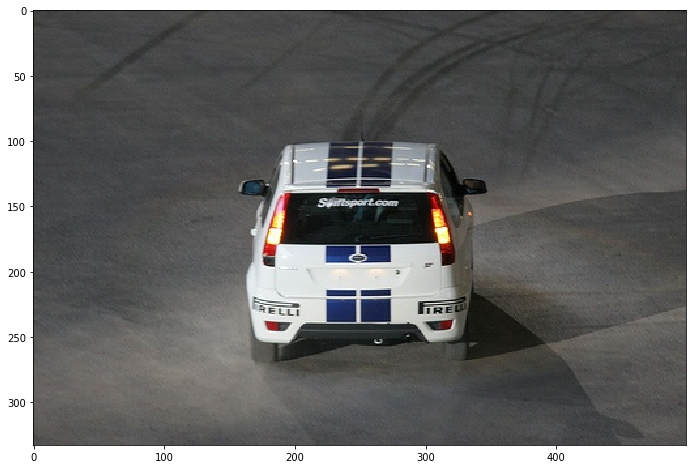

In [13]:
ax = show_img(im,figsize=(16,8))

In [14]:
bbox = mult_bbox.loc[0,'bbox']
y1,x1,y2,x2= map(int,bbox.split(' '))

In [15]:
def bb_wh(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]]) # x1,y1,width and height
wh = bb_wh([y1,x1,y2,x2])

In [16]:
wh

array([155,  96, 195, 173])

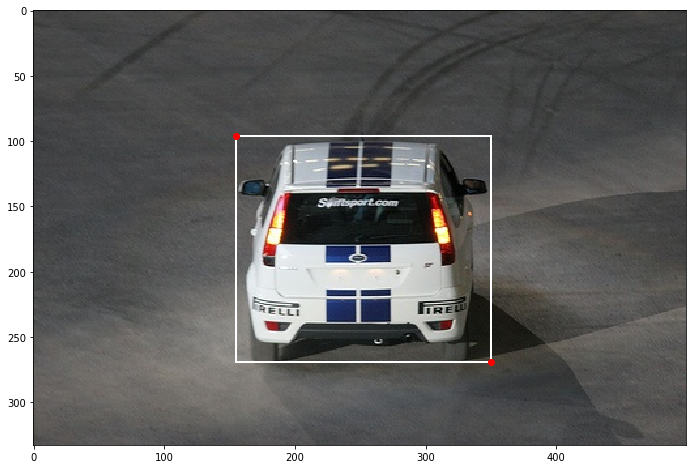

In [17]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth

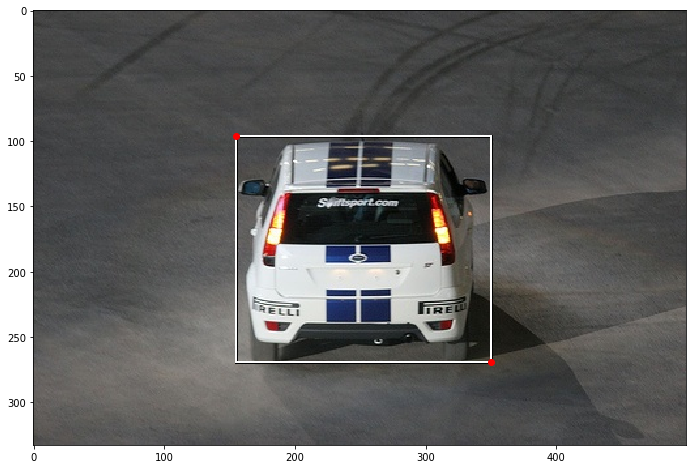

In [18]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
rec_patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth
#draw_outline: draw black border (inside and outside) to rectangle with patheffects.Stroke
lw=3
rec_patch.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

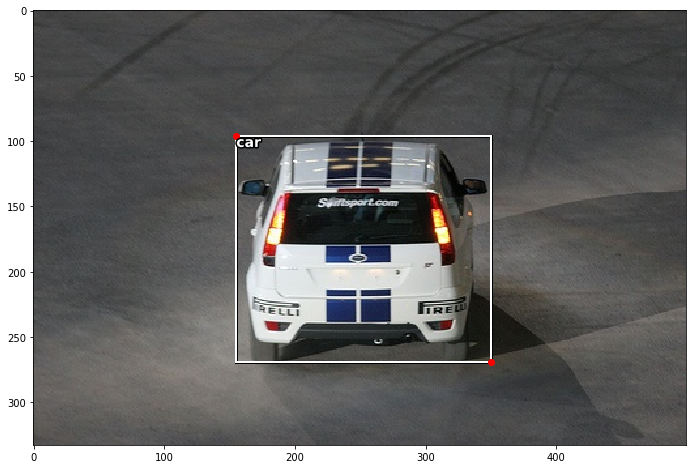

In [19]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth
#draw_outline: draw black border (inside and outside) to rectangle with patheffects.Stroke
lw=3
patch.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


#draw_text
text = ax.text(*wh[:2], 'car',
        verticalalignment='top', color='white', fontsize=14, weight='bold')
# draw black border to text
lw=3
text.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# Bounding box with multiple images

In [20]:
# Put all plotting steps above to into functions
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 3)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 2)
def bb_wh(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])



In [21]:
# get 12 colors, each with R-G-B-A values
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba
# 
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [22]:
colr_list

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0),
 (1.0, 1.0, 0.7019607843137254, 1.0),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961, 1.0),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0),
 (0.8, 0.9215686274509803, 0.7725490196078432, 1.0),
 (1.0, 0.9294117647058824, 0.43529411764705883, 1.0)]

In [23]:
X,y=to_np(next(iter(md.val_dl)))

In [24]:
X = md.trn_ds.ds.denorm(X)

In [25]:
print(y[1][0])
[bb_wh(o) for o in y[0][0].reshape(-1,4)]

[ 0  0  0  0  0  0  0  0  0  0  0  1 14 14]


[array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([ 47.,  91., 122., 132.], dtype=float32),
 array([ 49.,   0., 131., 205.], dtype=float32),
 array([169.,   9.,  53., 208.], dtype=float32)]

In [26]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_wh(o) for o in bbox.reshape(-1,4)]
    
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
        
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        # draw only when bbox's width >0 and pr > thres
        if((b[2]>0) and (pr is None or pr > thresh)): 
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            # txt contains: index (can be ignored) + class + probability (from activations)
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


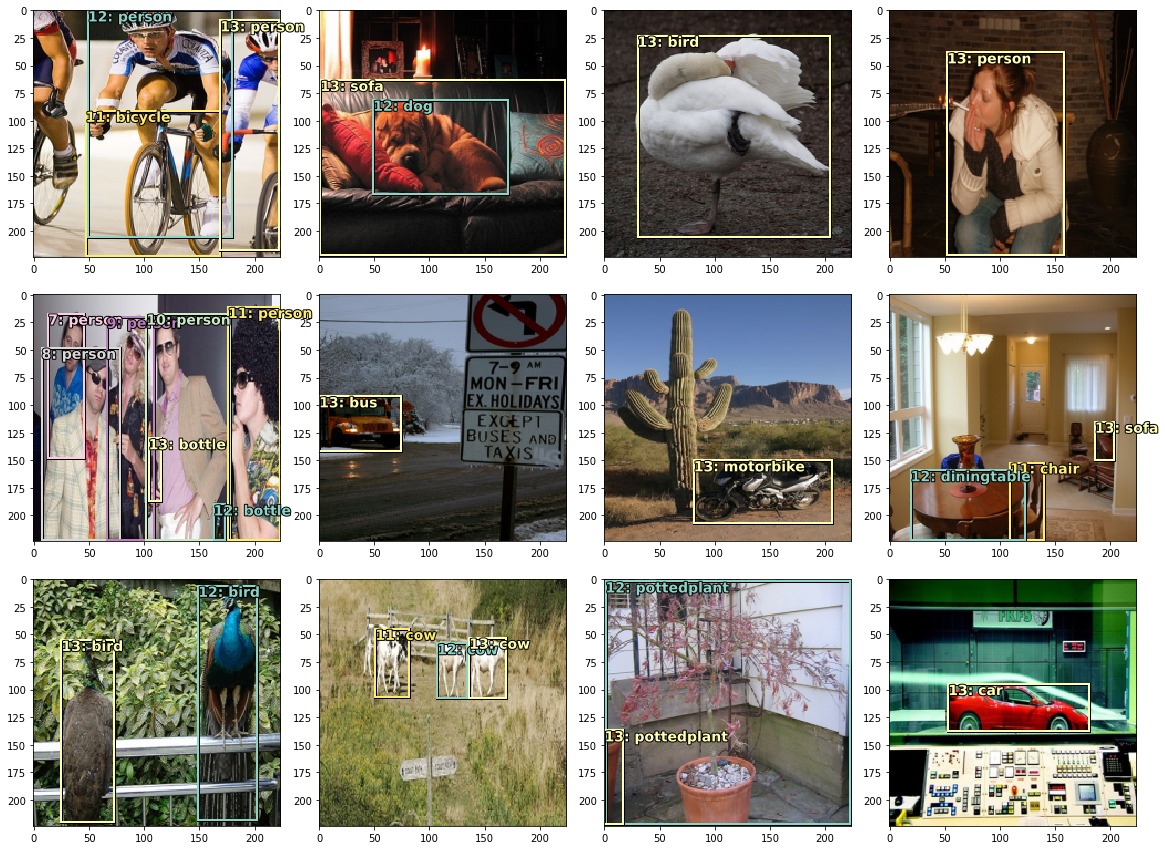

In [27]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, X[i], y[0][i], y[1][i])
plt.tight_layout()

# Anchor boxes

Goals:
- Produce anchor_cnr: (lower left, upper right) to calculate jaccard overlaps between bbox.data and anchor_cnr.data
- Produce anchors (y_center,x_center,w,h): to do an anchor-box transformation on model's activation (through actn_to_bb) -> produce a_ic

Note: both of these are scaled down to [0,1] and are torch Variable (torch.FloatTensor type) since they will be used during model training via pytorch

## 4x4 anchor box

In [28]:
anc_grid = 4 # 4x4 = 16 anchor boxes
k = 1

In [29]:
anc_offset = 1/(anc_grid*2) # offset b/t abox corner and its center

In [30]:
anc_offset

0.125

In [31]:
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

In [32]:
print(anc_x)
print(anc_y)

[0.125 0.125 0.125 0.125 0.375 0.375 0.375 0.375 0.625 0.625 0.625 0.625 0.875 0.875 0.875 0.875]
[0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875]


In [33]:
np.stack([anc_x,anc_y], axis=1).shape

(16, 2)

In [34]:
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (1,1))
anc_ctrs.shape

(16, 2)

In [35]:
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [36]:
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

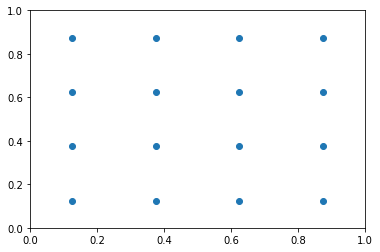

In [37]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [38]:
def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [39]:
anchor_cnr.size()

torch.Size([16, 4])

In [40]:
abox = to_np(anchor_cnr.data)*224

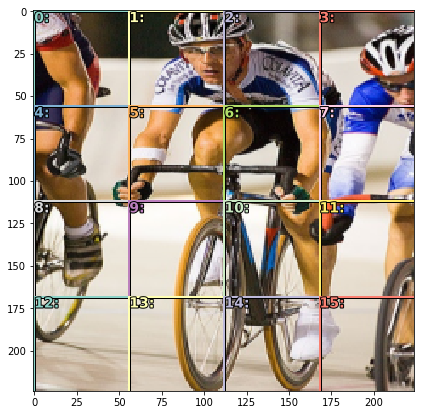

In [41]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[0], abox)

# IOU calculation (Jaccard)

In [42]:
bbox

'96 155 269 350'

In [43]:
idx=7

In [44]:
bbox_abox = np.concatenate([y[0][idx].reshape(-1,4),abox],axis=0)

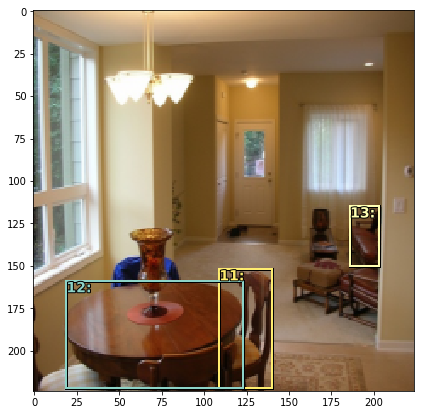

In [45]:
ig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[idx], y[0][idx].reshape(-1,4))

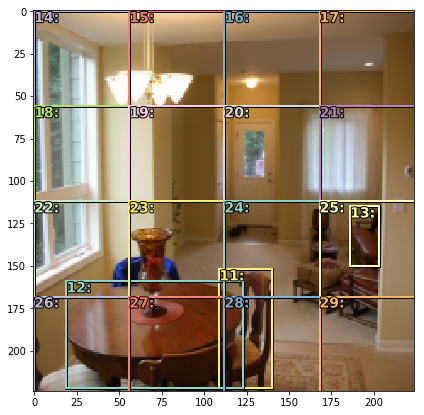

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[idx], bbox_abox)

## Calculate intersection area b/t each abox and each bbox

Note: bbox (ground-truth) and abox must be torch.Variable

In [47]:
X,y=to_np(next(iter(md.val_dl)))

In [48]:
X,y = V(X),V(y)

In [49]:
bbox,clas = get_y(y[0][idx],y[1][idx]) # get rid of 0 padding

In [50]:
type(anchor_cnr)
type(bbox)

torch.autograd.variable.Variable

torch.autograd.variable.Variable

We want to know max of lower left coord and min of upper right coord between abox and bbox <br>
- Max of abox and bbox lower left coord will be intersect box's lower left coord 
- Min of abox and bbox upper right coord will be intesect box's upper right coord

Specifically, we want max/min coord of each abox (16 a-boxes in this example) and bbox (3 in this example), for a total of 16 x 3 =  48 min coord and 48 max coord

We should have 2 3x16x2 matrices in the end. Then we can subtract them to get w and h of intersection area and multiply them to get area

### Calculating intersect box's upper right cord

In [51]:
# min of upper right
bbox.data.shape
bbox.data[:,None,2:] # turn into 3x1x2, which will be turned into 3x16x2 via broadcasting against abox

torch.Size([3, 4])


(0 ,.,.) = 
  0.9911  0.6250

(1 ,.,.) = 
  0.9911  0.5491

(2 ,.,.) = 
  0.6696  0.9063
[torch.cuda.FloatTensor of size 3x1x2 (GPU 0)]

In [52]:
anchor_cnr.data.shape
anchor_cnr.data[None,:,2:] # turn into 1x16x2, which will be turned into 3x16x2 via broadcasting against bbox

torch.Size([16, 4])


(0 ,.,.) = 
  0.2500  0.2500
  0.2500  0.5000
  0.2500  0.7500
  0.2500  1.0000
  0.5000  0.2500
  0.5000  0.5000
  0.5000  0.7500
  0.5000  1.0000
  0.7500  0.2500
  0.7500  0.5000
  0.7500  0.7500
  0.7500  1.0000
  1.0000  0.2500
  1.0000  0.5000
  1.0000  0.7500
  1.0000  1.0000
[torch.cuda.FloatTensor of size 1x16x2 (GPU 0)]

In [53]:
# min of upper right
torch.min(bbox.data[:,None,2:],anchor_cnr.data[None,:,2:])


(0 ,.,.) = 
  0.2500  0.2500
  0.2500  0.5000
  0.2500  0.6250
  0.2500  0.6250
  0.5000  0.2500
  0.5000  0.5000
  0.5000  0.6250
  0.5000  0.6250
  0.7500  0.2500
  0.7500  0.5000
  0.7500  0.6250
  0.7500  0.6250
  0.9911  0.2500
  0.9911  0.5000
  0.9911  0.6250
  0.9911  0.6250

(1 ,.,.) = 
  0.2500  0.2500
  0.2500  0.5000
  0.2500  0.5491
  0.2500  0.5491
  0.5000  0.2500
  0.5000  0.5000
  0.5000  0.5491
  0.5000  0.5491
  0.7500  0.2500
  0.7500  0.5000
  0.7500  0.5491
  0.7500  0.5491
  0.9911  0.2500
  0.9911  0.5000
  0.9911  0.5491
  0.9911  0.5491

(2 ,.,.) = 
  0.2500  0.2500
  0.2500  0.5000
  0.2500  0.7500
  0.2500  0.9063
  0.5000  0.2500
  0.5000  0.5000
  0.5000  0.7500
  0.5000  0.9063
  0.6696  0.2500
  0.6696  0.5000
  0.6696  0.7500
  0.6696  0.9063
  0.6696  0.2500
  0.6696  0.5000
  0.6696  0.7500
  0.6696  0.9063
[torch.cuda.FloatTensor of size 3x16x2 (GPU 0)]

In [54]:
# you can also broadcast to 16x3x2. Same result!
# broadcast to 16x3x2: torch.min(bbox.data[None,:,2:],anchor_cnr.data[:,None,2:])
torch.sum(torch.min(bbox.data[:,None,2:],anchor_cnr.data[None,:,2:]) != torch.min(bbox.data[None,:,2:],anchor_cnr.data[:,None,2:]).permute(1,0,2).contiguous())

0

Repeat the same process for calculating intersection's lower left coord

## Calculate union area

In [55]:
def box_area(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))
# calculate area of a box

In [56]:
box_area(bbox.data)
box_area(anchor_cnr.data)


 0.0432
 0.1306
 0.0119
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
  6.2500
[torch.cuda.FloatTensor of size 16 (GPU 0)]

In [57]:
# broadcasting so final result shape is 3x16
box_area(bbox.data)[:,None] + box_area(anchor_cnr.data)[None,:]



Columns 0 to 9 
 0.1057  0.1057  0.1057  0.1057  0.1057  0.1057  0.1057  0.1057  0.1057  0.1057
 0.1931  0.1931  0.1931  0.1931  0.1931  0.1931  0.1931  0.1931  0.1931  0.1931
 0.0744  0.0744  0.0744  0.0744  0.0744  0.0744  0.0744  0.0744  0.0744  0.0744

Columns 10 to 15 
 0.1057  0.1057  0.1057  0.1057  0.1057  0.1057
 0.1931  0.1931  0.1931  0.1931  0.1931  0.1931
 0.0744  0.0744  0.0744  0.0744  0.0744  0.0744
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [58]:
# broadcasting so final result shape is 3x16
box_area(bbox.data)[:,None].shape
box_area(bbox.data).unsqueeze(0).shape
box_area(anchor_cnr.data)[None,:].shape
box_area(anchor_cnr.data).unsqueeze(1).shape

torch.Size([3, 1])

torch.Size([1, 3])

torch.Size([1, 16])

torch.Size([16, 1])

## Calculate jaccard (IOU)

In [59]:
def jaccard(bbox,abox):
    '''
    bbox: FloatTensor, shape (# of labels, 4)
    abox: FloatTensor, shape (# of aboxes, 4)
    '''
    #calculate intersect area
    
    ## get upper right (y2 x2) minimum between abox and bbox
    inter_upper_right = torch.min(bbox[:, None, 2:], abox[None, :, 2:])
    ## get lower left (y1 x1) maximum between abox and bbox
    inter_lower_left = torch.max(bbox[:, None, :2], abox[None, :, :2])
    inter_hw = inter_upper_right-inter_lower_left # height and width of intersect area for 16 aboxes and 3 bboxes. Shape: 3x16x2
    inter_hw = torch.clamp(inter_hw, min=0) # for bbox and abox with no intersection, w and h are negative, so set lower bound to 0
    inter_area= inter_hw[:, :, 0] * inter_hw[:, :, 1] # area = width * height
    
    
    # calculate union area: just add area of 2 boxes and minus inter_area
    union_area = box_area(bbox)[:,None] + box_area(abox)[None,:] - inter_area
    return inter_area / union_area

In [60]:
jaccard(bbox.data,anchor_cnr.data)



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

# Actn_to_bb function

anchor-box transformation on model's activation (through actn_to_bb) <br>
Required: anchors (y_center,x_center,w,h)

In [61]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [62]:
def actn_to_bb(actn, anchors):
    '''
    Convert conv2d bbox output for 1 img to a (16,4 coord lower left upper right) matrix based on anchor box h,w and center
    
    actn: (16,4) y1x1 y2x2
    anchors: (16,4) center_y,center_x,w,h (w=h=grid_sizes)
    '''
    actn_bbs = torch.tanh(actn) # scale b/t -1 and 1
    
    # move center of anchor box around actn/2
    # each preditive bbox can be moved by up to 50% of a grid size where its default position (anchor box) is
    # TODO: ???
    
    # move anchors center by: first 2 values of activations multiply to (grid_sizes / 2). This will be activation centers
    actn_centers = (actn_bbs[:,:2]* (grid_sizes / 2)) + anchors[:,:2]
    # take half of last 2 values of activations, add 1, then multiply to height and width of anchors. This will be activation h and w
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [63]:
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

# More anchors

Creating 9 anchor boxes for each conv2d grid cells. I.e for 4x4 convo (16 grid cells), we have a total of 16*9 anchor boxes <br>
3 different zooms (.7, 1, 1.3) and 3 different layout (square, vertical rectangle, horizontal rectangle)

In [64]:


anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)

anc_grids = [4,2,1]
# anc_grids = [2]
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [65]:
anchor_scales

[(0.7, 0.7),
 (0.7, 0.35),
 (0.35, 0.7),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (1.3, 1.3),
 (1.3, 0.65),
 (0.65, 1.3)]

In [71]:
anc_grids
anc_offsets

[4, 2, 1]

[0.125, 0.25, 0.5]

In [66]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [69]:
print(anc_x)
print(anc_y)

[0.125 0.125 0.125 0.125 0.375 0.375 0.375 0.375 0.625 0.625 0.625 0.625 0.875 0.875 0.875 0.875 0.25  0.25
 0.75  0.75  0.5  ]
[0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.25  0.75
 0.25  0.75  0.5  ]


In [72]:
len(anc_ctrs)

189

189 = (16 cells from 4x4 convo)x9 + (4 cells from 2x2 convo)x9 + (1 cells from 1x1 convo)x9

In [73]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [76]:
anchors

Variable containing:
 0.1250  0.1250  0.1750  0.1750
 0.1250  0.1250  0.1750  0.0875
 0.1250  0.1250  0.0875  0.1750
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.1250  0.2500  0.1250
 0.1250  0.1250  0.1250  0.2500
 0.1250  0.1250  0.3250  0.3250
 0.1250  0.1250  0.3250  0.1625
 0.1250  0.1250  0.1625  0.3250
 0.1250  0.3750  0.1750  0.1750
 0.1250  0.3750  0.1750  0.0875
 0.1250  0.3750  0.0875  0.1750
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.3750  0.2500  0.1250
 0.1250  0.3750  0.1250  0.2500
 0.1250  0.3750  0.3250  0.3250
 0.1250  0.3750  0.3250  0.1625
 0.1250  0.3750  0.1625  0.3250
 0.1250  0.6250  0.1750  0.1750
 0.1250  0.6250  0.1750  0.0875
 0.1250  0.6250  0.0875  0.1750
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.6250  0.2500  0.1250
 0.1250  0.6250  0.1250  0.2500
 0.1250  0.6250  0.3250  0.3250
 0.1250  0.6250  0.3250  0.1625
 0.1250  0.6250  0.1625  0.3250
 0.1250  0.8750  0.1750  0.1750
 0.1250  0.8750  0.1750  0.0875
 0.1250  0.8750  0.0875  0.1750
 0.1250  0.8750  0.

In [77]:
anchor_cnr.size()

torch.Size([189, 4])

In [81]:
X,y=to_np(next(iter(md.val_dl)))
X=md.val_ds.ds.denorm(X)

In [82]:
anchors_cnr_2 = anchor_cnr[-9:]

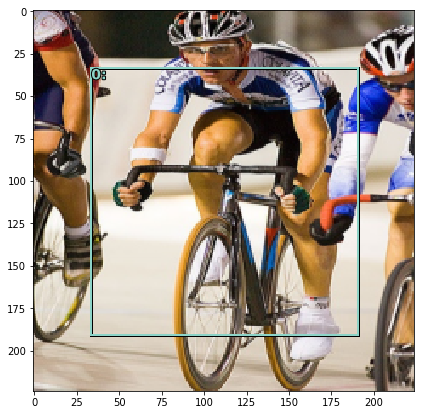

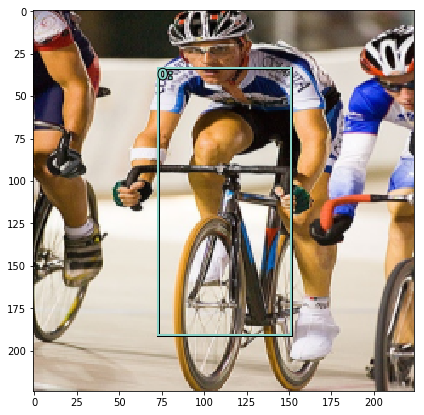

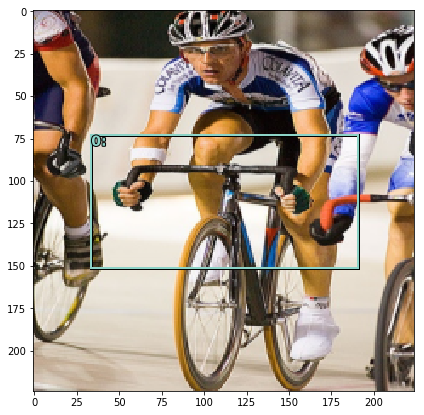

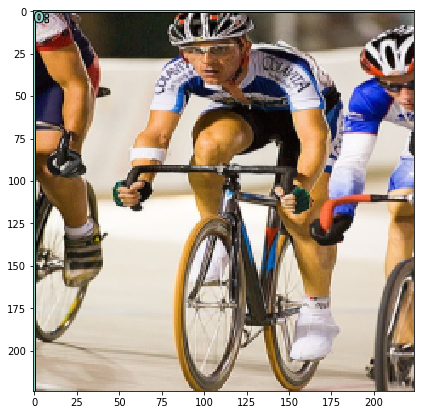

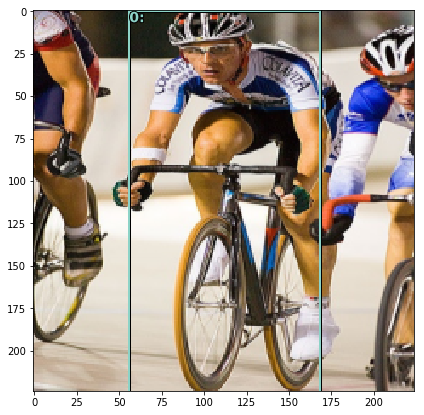

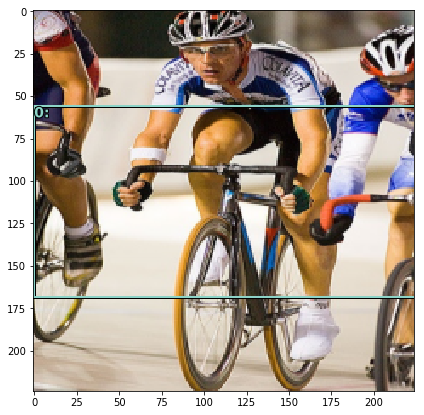

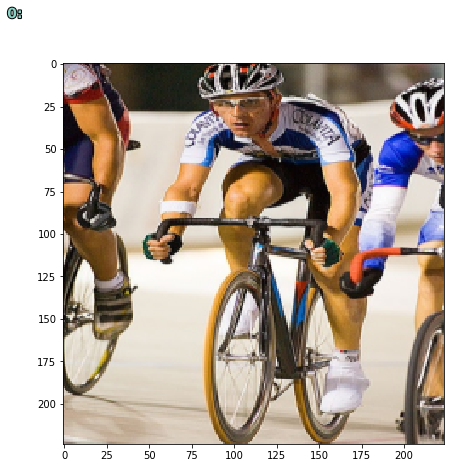

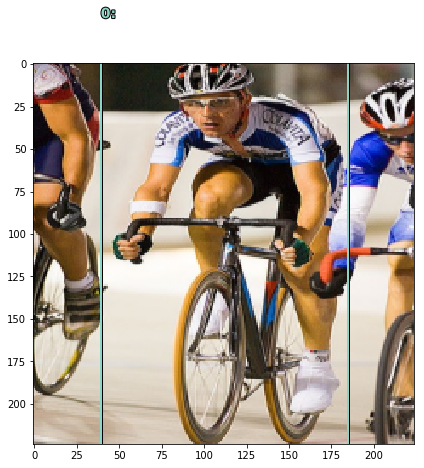

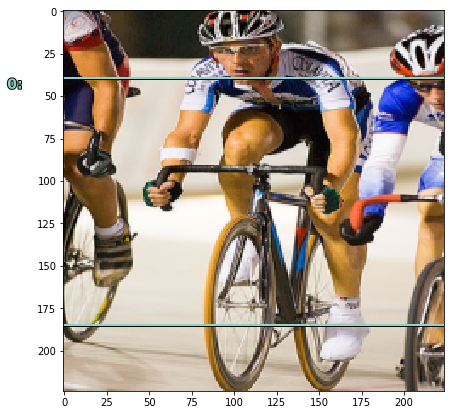

In [86]:
abox = to_np(anchors_cnr_2.data)*224
for i in abox:   
    fig, ax = plt.subplots(figsize=(7,7))
    show_ground_truth(ax, X[0], i)

The last 3 aboxes are at scale 1.3. TODO: why we need aboxes that is totallyigger than the picture